# Introduction to the DEA Intertidal Product Suite <img align="right" src="../Supplementary_data/dea_logo.jpg">


## Background

Pull it from the new docs/CMI

## Description

This notebook introduces the Digital Earth Australia (DEA) Intertidal Product Suite.
All datasets are produced by DEA and are accessible in the DEA product archive.
They can also be explored via [DEA Maps](https://maps.dea.ga.gov.au/).

In this notebook, users will:
- learn about the datasets and how they are inter-related
- interact with datasets including how to load your own area-of-interest, visualise, interpret and export data in GIS-ready formats
- explore basic use cases

By the end of this notebook, users should have an understanding of what these datasets are, how they can be used, their limitations and what the fixed parameters are.
To begin customising these parameters, such as time-period and exposure options, users can explore *this (future) notebook*.

## Getting started - TODO following indexing of intertidal suite

Provide any particular instructions that the user might need, e.g. To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

Use standard import commands; some are shown below. 
Begin with any `iPython` magic commands, followed by standard Python packages, then any additional functionality you need from the `Scripts` directory.

In [3]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.plotting import rgb


### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [ ]:
dc = datacube.Datacube(app='DEA_notebooks_template')

### Analysis parameters

Probably not relevant to this notebook


## Available products and measurements - TODO following indexing
Use headings to break up key steps/stages of the notebook.

Use markdown text for detailed, descriptive text explaining what the code below does and why it is needed.

> **Note:** Use this markdown format (sparingly) to draw particular attention to an important point or caveat

In [ ]:
# Use code comments for low-level documentation of code
a = 1

### List Products
Use subheadings to break up steps within a single section.

In [ ]:
# Use code comments for low-level documentation of code
b = 2

In [ ]:
dea_intertidal/dea-intertidal/data/interim/Groote_Eylandt_Feb2024/x98y123/2021-2023/x98y123_2021_2023_elevation.tif

### List Measurements
Use subheadings to break up steps within a single section.

## Load data - TODO: load indexed data instead of this temporary workaround

Users need to be able to DIY their own areas and then be able to export to COG in this workflow.

In [22]:
## Temporary - load from COGs stored locally. Replace with indexed workflow down the track.

geotiff_path = '../../data/interim/Groote_Eylandt_Feb2024/x99y124/2021-2023/x99y124_2021_2023_'

file_path = 'elevation.tif'

# Load the first dataset to establish the dimensions on the master 'intertidal' ds
da = rioxarray.open_rasterio(geotiff_path + file_path)
ds = da.to_dataset('band')
ds = ds.rename({1:'elevation'})
intertidal = ds.copy(deep=True)

layer_names = ['oa_offset_hightide',
               'oa_offset_lowtide',
               'oa_spread',
               'oa_hot',
               'oa_lot',
               'oa_hat',
               'oa_lat',
               'exposure_unfiltered',
               'extents',
               'elevation_uncertainty'
              ]

# Loop through and add the files of interest to the master ds
for file in layer_names:
    da = rioxarray.open_rasterio(geotiff_path + file + '.tif')
    ds = da.to_dataset('band')
    ds = ds.rename({1:file})
    intertidal[str(file)] = ds[str(file)]

# Inspect the master dataset
intertidal

<xarray.Dataset>
Dimensions:                (y: 3200, x: 3200)
Coordinates:
  * x                      (x) float64 4.8e+05 4.8e+05 ... 5.12e+05 5.12e+05
  * y                      (y) float64 -1.472e+06 -1.472e+06 ... -1.504e+06
    spatial_ref            int64 0
Data variables:
    elevation              (y, x) float32 ...
    oa_offset_hightide     (y, x) int16 ...
    oa_offset_lowtide      (y, x) int16 ...
    oa_spread              (y, x) int16 ...
    oa_hot                 (y, x) float32 ...
    oa_lot                 (y, x) float32 ...
    oa_hat                 (y, x) float32 ...
    oa_lat                 (y, x) float32 ...
    exposure_unfiltered    (y, x) float32 ...
    extents                (y, x) int16 ...
    elevation_uncertainty  (y, x) float32 ...
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

## Intertidal Extents

### Description

The DEA Intertidal Extents dataset classifies pixels into coastal classes, including the intertidal zone, inland or tidal persistent wet regions, inland intermittent wet regions and dry land.
This coastal zone classifier exploits the relationship between remotely sensed water in time-series and modelled tide-height.
Two intertidal classes are identified.
Low-confidence intertidal pixels usually fringe high-confidence intertidal regions.
These latter high-confidence pixels represent the same pixels from which intertidal elevation and exposure are calculated in this DEA Intertidal Product suite.

More information on the method for classifying Intertidal Extents can be found in the (Product Description)[Link-TODO]

Coastal classes represented in the DEA Intertidal Extents dataset are as follows.
| Class Value | Class Label | Class Description |
| ------- | ------- | --------- |
| 0 | Dry | Pixels that are frequently detected as dry. This class also includes urban pixels that are misclassified as wet and intermittently wet pixels on the inland fringe of the intertidal zone that are close to the 'dry' threshold yet are uncorrelated to tide. |
| 1 | Inland intermittent wet | Pixels that are variably detected as wet through the time-series but are uncorrelated to tide, unconnected to the intertidal class and do not intersect with urban areas. This class includes semi-permanent water bodies and water features whose connection to the intertidal class has changed during the time-series and includes intermittently closed and open lakes and lagoons (ICOLLs).  |
| 2 | Inland persistent wet  | Pixels that are frequently detected as wet and are unconnected to the intertidal class. This class will include coastal lakes and lagoons that were wet and unconnected to intertidal pixels for the entire time-series. |
| 3 | Tidal influenced persistent wet | Pixels that are frequently detected as wet and are connected to the intertidal class. This class also includes pixels that are variably detected as wet and are connected to the intertidal class, despite being uncorrelated to tide. This class typically includes the ocean and tide channels. |
| 4 | Intertidal low confidence | Pixels that are variably detected as wet and are correlated to tide yet do not have a valid elevation value. These pixels often fringe the intertidal zone and are likely to be intertidal but are included in the low confidence class as their variability with tide occurs completely above or below the wet/dry frequency threshold. |
| 5 | Intertidal high confidence | Pixels that are variably detected as wet, are correlated with tide and have a valid elevation value. The pixels in class should exactly match the DEA Elevation and DEA Exposure footprints. |

### Plot and View - TODO
Show what it looks like visually and in a dataarray

In [24]:
# Inspect the data
intertidal.extents

<xarray.DataArray 'extents' (y: 3200, x: 3200)>
[10240000 values with dtype=int16]
Coordinates:
  * x            (x) float64 4.8e+05 4.8e+05 4.8e+05 ... 5.12e+05 5.12e+05
  * y            (y) float64 -1.472e+06 -1.472e+06 ... -1.504e+06 -1.504e+06
    spatial_ref  int64 0

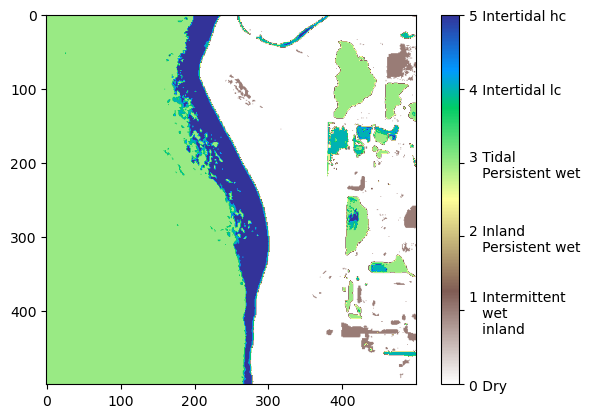

In [52]:
#Plot the data with labels

## Plot with labels
labels=['0 Dry',
       '1 Intermittent\n   wet\n   inland',
       '2 Inland\n   Persistent wet',
       '3 Tidal\n   Persistent wet',
       '4 Intertidal lc',
       '5 Intertidal hc',
       ]

fig,ax=plt.subplots()
cax=ax.imshow(intertidal['extents'].isel(y=slice(1500,2000),x=slice(0,500)), cmap='terrain_r')
cbar=fig.colorbar(cax, ticks=[0,1,2,3,4,5])
cbar.ax.set_yticklabels(labels)
plt.show()

# intertidal.extents.plot()

### Limitations and Caveats - TODO

## Intertidal Elevation

### Description
DEA Intertidal Elevation provides elevation in metre units relative to modelled Mean Sea Level for each pixel of intertidal terrain across the Australian coastline. 
The elevation model is generated from DEA Landsat and Sentinel-2 data surface reflectance from 2019-21, utilising a pixel-based approach and ensemble tidal modelling.
For every pixel, the time-series of surface reflectance data is converted to the Normalised Difference Water Index (NDWI), and each pixel-observation tagged with the tidal height modelled at the time of acquisition by the satellite. 
A rolling median is applied from low to high tide to reduce noise (e.g. white water, sunglint, non-tidal water level variability), then analysed to identify the tide height at which the pixel transitions from dry to wet. 
This tide height represents the elevation of the pixel. 

The spatial footprint of the Intertidal Elevation dataset is identical to the 'Intertidal high confidence' class in the Intertidal Extents dataset.
Note though that the 'Intertidal low condfidence' class is *not* included in Intertidal Elevation. 
Furthermore, the Intertidal Elevation Uncertainty dataset is a companion dataset that quantifies uncertainty in the elevation values.
It is introduced in detail below.
DEA Intertidal Elevation is also critical for the calculation of the Intertidal Exposure dataset, which is also introduced in detail below.

### Plot and View - TODO
Show what it looks like visually and in a dataarray

In [32]:
# Inspect the data
intertidal.elevation

<xarray.DataArray 'elevation' (y: 3200, x: 3200)>
[10240000 values with dtype=float32]
Coordinates:
  * x            (x) float64 4.8e+05 4.8e+05 4.8e+05 ... 5.12e+05 5.12e+05
  * y            (y) float64 -1.472e+06 -1.472e+06 ... -1.504e+06 -1.504e+06
    spatial_ref  int64 0

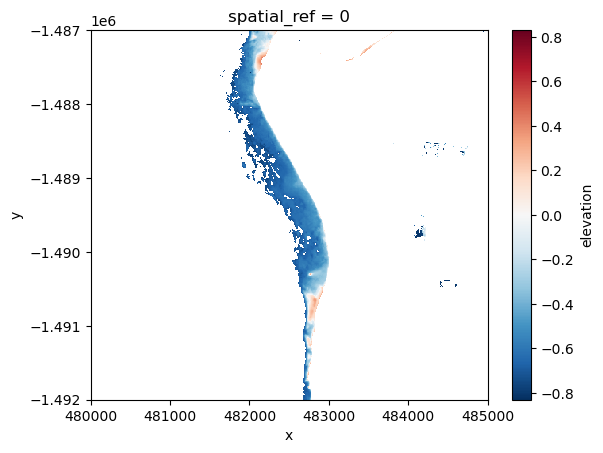

In [53]:
# Plot the data
intertidal.elevation.isel(y=slice(1500,2000),x=slice(0,500)).plot()

### Limitations and Caveats - TODO
Note any data limitations/caveats

## Intertidal Elevation Uncertainty

### Description

DEA Intertidal Elevation Uncertainty provides a measure of the quality of each modelled elevation in metre units. 
Uncertainty is calculated by assessing how cleanly the modelled elevation separates satellite observations into dry and wet observations. 
This is achieved by identifying satellite observations that were misclassified by the modelled elevation (e.g. pixels that were wet at tide heights lower than the modelled elevation, or dry at higher tide heights). 
The spread of the tide heights of these misclassified points are then summarised using a robust Median Absolute Deviation statistic. 
Common causes of high elevation uncertainty can be poor tidal model performance, rapidly changing intertidal morphology, or noisy underlying satellite data. 

### Plot and View - TODO
Show what it looks like visually and in a dataarray

In [34]:
# Inspect the data
intertidal.elevation_uncertainty

<xarray.DataArray 'elevation_uncertainty' (y: 3200, x: 3200)>
[10240000 values with dtype=float32]
Coordinates:
  * x            (x) float64 4.8e+05 4.8e+05 4.8e+05 ... 5.12e+05 5.12e+05
  * y            (y) float64 -1.472e+06 -1.472e+06 ... -1.504e+06 -1.504e+06
    spatial_ref  int64 0

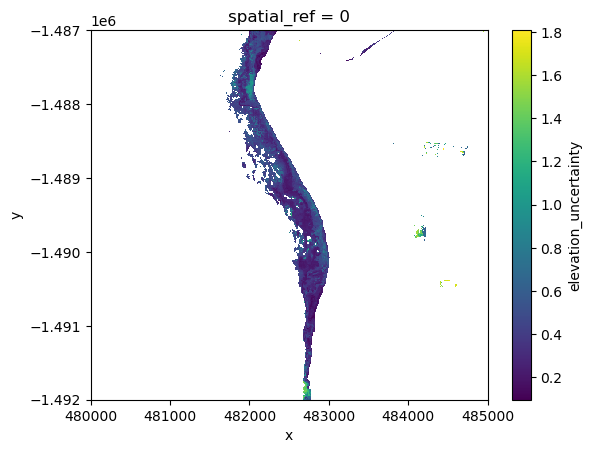

In [54]:
# Plot the data
intertidal.elevation_uncertainty.isel(y=slice(1500,2000),x=slice(0,500)).plot()

### Limitations and Caveats - TODO
Note any data limitations/caveats

## Intertidal Exposure

### Description

DEA Intertidal Exposure models the relative amount of time that any intertidal pixel is exposed from seawater coverage. 
Exposure is calculated by translating a pixels elevation back against a high temporal resolution model of tide heights for that location. 
Exposure times reflect the amount of time that pixel, of known elevation, is exposed from seawater as a fraction of the whole tide-modelling time period.

### Plot and View - TODO
Show what it looks like visually and in a dataarray

In [36]:
# Inspect the data
intertidal.exposure_unfiltered

<xarray.DataArray 'exposure_unfiltered' (y: 3200, x: 3200)>
[10240000 values with dtype=float32]
Coordinates:
  * x            (x) float64 4.8e+05 4.8e+05 4.8e+05 ... 5.12e+05 5.12e+05
  * y            (y) float64 -1.472e+06 -1.472e+06 ... -1.504e+06 -1.504e+06
    spatial_ref  int64 0

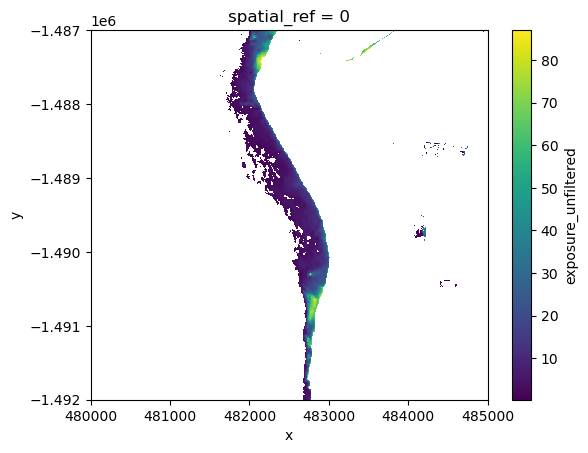

In [55]:
# Plot the data
intertidal.exposure_unfiltered.isel(y=slice(1500,2000),x=slice(0,500)).plot()

### Limitations and Caveats - TODO
Note any data limitations/caveats

## Intertidal Observation Attributes

The DEA Intertidal Observation Attributes are a suite of datasets that describe the tidal and some specific satellite behaviours that relate to every coastal pixel observation.
These datasets describe fundamental tidal characteristics for each pixel that both underpin the workflows included in the DEA Intertidal Product Suite, and are important to understand for complete interpretation of all satellite-derived intertidal datasets.

The DEA Intertidal Observation Attributes are grouped into two categories: the highest and lowest observed and astronomical tides, and the satellite observed tidal offsets.

### Highest/Lowest Astronomical and Satellite-Observed Tides

Datasets of the highest and lowest astronomical and satellite-observed tide heights are foundational metadata that describe some satellite and tidal behaviours around the coastline.
These datasets are used to produce the following satellite-observed tidal offset datasets which are useful to understand how tide heights are mapped around the coastline and to interpret satellite-derived intertidal datasets.

In this work, the astronomical tide heights are considered to be the modelled tide heights, generated from the ensemble tidal modelling workflow.

#### Description

Four datasets are included in this part of the product suite.
They include the following:
| Dataset | Description |
| ---- | --- |
|DEA Intertidal Lowest Observed Tide| The lowest observed tide dataset maps the lowest observed tide (LOT) of the satellite time-series at each pixel during the analysis epoch, with tide-heights determined based on ensemble tide modelling. |
|DEA Intertidal Highest Observed Tide| The highest observed tide dataset maps the highest observed tide (HOT) of the satellite time-series at each pixel during the analysis epoch, with tide-heights determined based on ensemble tide modelling. |
| DEA Intertidal Lowest Astronomical Tide | The lowest astronomical tide dataset maps the lowest astronomical tide (LAT) for each pixel as  determined based on ensemble tide modelling. |
| DEA Intertidal Highest Astronomical Tide | The highest astronomical tide dataset maps the highest astronomical tide (HAT) for each pixel as  determined based on ensemble tide modelling. |

#### Plot and View - TODO
Show what it looks like visually and in a dataarray

In [ ]:
# Inspect the data

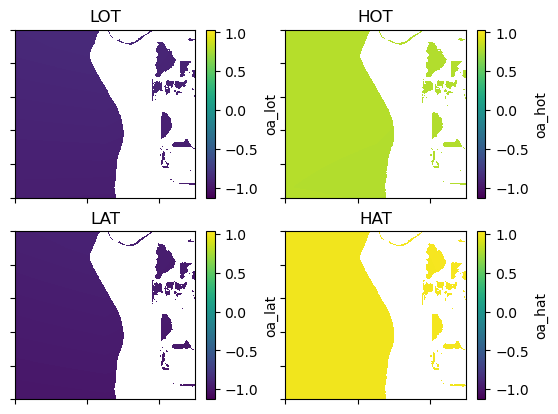

In [96]:
# Plot the data

# Identify the maxima and minima from the combined arrays to enable plotting them on a single color scale
minmax = np.array([intertidal.oa_lot.min(), intertidal.oa_lot.max(), intertidal.oa_lat.min(), intertidal.oa_lat.max(),intertidal.oa_hot.min(), intertidal.oa_hot.max(), intertidal.oa_hat.min(), intertidal.oa_hat.max()])

fig, axs = plt.subplots(2,2)
intertidal.oa_lot.isel(y=slice(1500,2000),x=slice(0,500)).plot(ax=axs[0,0], vmin=minmax.min(), vmax=minmax.max())
axs[0,0].set_title('LOT')
intertidal.oa_hot.isel(y=slice(1500,2000),x=slice(0,500)).plot(ax=axs[0,1], vmin=minmax.min(), vmax=minmax.max())
axs[0,1].set_title('HOT')
intertidal.oa_lat.isel(y=slice(1500,2000),x=slice(0,500)).plot(ax=axs[1,0], vmin=minmax.min(), vmax=minmax.max())
axs[1,0].set_title('LAT')
intertidal.oa_hat.isel(y=slice(1500,2000),x=slice(0,500)).plot(ax=axs[1,1], vmin=minmax.min(), vmax=minmax.max())
axs[1,1].set_title('HAT')

# Format the plot
for ax in axs.flat:
    ax.label_outer()
    ax.set_xticklabels(labels='')
    ax.set_yticklabels(labels='')
    ax.set_xlabel('')
    ax.set_ylabel('')

#### Limitations and Caveats - TODO
Note any data limitations/caveats

### Satellite-Observed Tidal Offsets
Satellite-observed tidal offsets describe the relative difference between the actual (astronomical) tide range at any location with the tide-range observed by the satellite - in this case, any of Landsat 8, Landsat 9, Sentinel-2A or Sentinel-2B.
Due to the sun-synchronous, orbiting nature of these satellites, daily overpass (image aquisition) times are always approximately the same. 
This introduces a bias against complete imaging of the full tidal range in many locations.

#### Description
The datasets included in this part of the DEA Intertidal Product Suite characterise, for every coastal pixel, the:
| Dataset | Description |
| ---- | --- |
| DEA Intertidal High Tide Offset | The offset at the top of the tide range from complete satellite-observation of the astronomical tide range (0% offset) to values up to 40% in some regions, representing failure of the satellite to observe the top 40% of astronomical tides |
| DEA Intertidal Low Tide Offset | The offset at the bottom of the tide range from complete satellite-observation of the astronomical tide range (0% offset) to values up to 40% in some regions, representing failure of the satellite to observe the lowest 40% of astronomical tides |
| DEA Intertidal Tidal Spread| The spread of astronomical tide heights observed by the satellite as a percentage|

#### Plot and View - TODO
Show what it looks like visually and in a dataarray

In [97]:
# Inspect the data

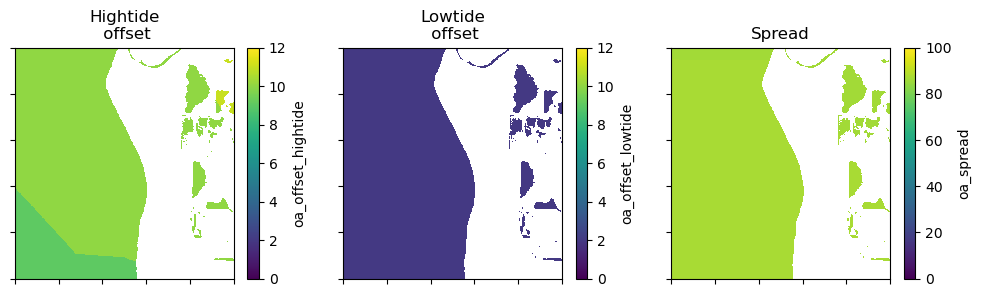

In [126]:
# Plot the data

minmax = np.array([intertidal.oa_offset_hightide.min(), intertidal.oa_offset_hightide.max(), intertidal.oa_offset_lowtide.min(), intertidal.oa_offset_lowtide.max()])

fig, axs = plt.subplots(1,3, figsize=(12, 3))
intertidal.oa_offset_hightide.isel(y=slice(1500,2000),x=slice(0,500)).where(intertidal.oa_offset_hightide > intertidal.oa_offset_hightide.min()).plot(ax=axs[0], vmin=0, vmax=minmax.max())
axs[0].set_title('Hightide\n offset')
intertidal.oa_offset_lowtide.isel(y=slice(1500,2000),x=slice(0,500)).where(intertidal.oa_offset_lowtide > intertidal.oa_offset_lowtide.min()).plot(ax=axs[1], vmin=0, vmax=minmax.max())
axs[1].set_title('Lowtide\n offset')
intertidal.oa_spread.isel(y=slice(1500,2000),x=slice(0,500)).where(intertidal.oa_spread > intertidal.oa_spread.min()).plot(ax=axs[2], vmin=0, vmax=100)
axs[2].set_title('Spread')

# Format the plot
for ax in axs.flat:
    # ax.label_outer()
    ax.set_xticklabels(labels='')
    ax.set_yticklabels(labels='')
    ax.set_xlabel('')
    ax.set_ylabel('')
# plt.show()

#### Limitations and Caveats - TODO
Note any data limitations/caveats

In [ ]:
# Use code comments for low-level documentation of code
c = 3

## Use Case - TODO

Rationale/Purpose - Show users how they might use some of these datasets together (using the loaded ds), interpret the results and export the data (assuming they're more likely to be GIS users and want to consider this information relative to other datasets in their area of interest).
**Question:** Should we build this in a separate notebook and link to it at the bottom of this one? (This notebook is already unusually long for a dea-notebook).

Proposal
- users choose a small aoi
- load the full product suite


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** January 2024

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags - TODO
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)